# Download the Data

In [9]:
import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path

import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri

from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']


In [14]:
def download(download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print(f'Downloading {target_file} ...')
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
        else:
            print(f'Already downloaded {target_file}')

def extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        target_dir = target_file.replace('.tar.gz', '')
        assert target_file in os.listdir(download_dir), f'{target_file} not found in {download_dir}'
        if target_dir not in os.listdir(data_dir):
            print(f'Extracting {target_file} ...')
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print(f'Already extracted {target_file}')


Path('data').mkdir(parents=True, exist_ok=True)

download('.')
extract('data', '.')


Already downloaded images.tar.gz
Already downloaded annotations.tar.gz
Extracting images.tar.gz ...
Extracting annotations.tar.gz ...


# Visualize Data

Even thought the "annotations" directory have more masks (`.png`) than the actual images (`.jpg`) in the "images" directory, we'll only use the ones we need (the ones we have the `.jpg` for).

The structure of the files is like `image_name.jpg` and then the mask with the same name but with a `.png` extension.

In [25]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(f"num of masks: {len(maps)}")

num of masks: 14780


In [24]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(f"num of images:{len(images)}")

num of images:7390


In [27]:
images[5]

'german_shorthaired_89.jpg'

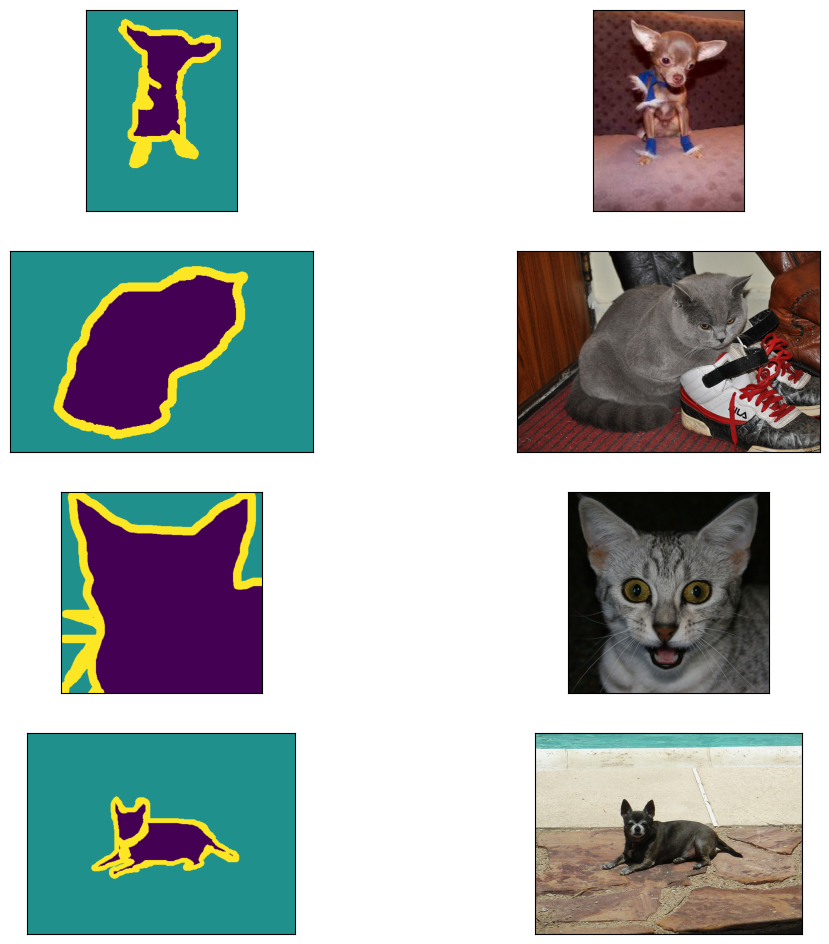

In [31]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [33]:
# number of classes in the mask
# a class for background, a class for the object (forground), and a class for the object boundary (or also known as niether region)
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [ ]:
# create a sagemaker role
role = sagemaker.get_execution_role()

# A bucket is a fundamental storage container within AWS Simple Storage Service (S3).
# A bucket provides a secure and scalable way to store and retrieve any amount of data from anywhere on the web.
bucket_name = "petbucket"

# we'll be using the sagemaker's built-in semantic segmentation algorithm

training_image = get_image_uri(boto3.Session().region_name, 'semantic')

In [ ]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [ ]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

In [ ]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [ ]:
print(len(train_annots), len(train_images))

# Uploading Data to S3

# SageMaker Estimator

# Hyperparameters

# Data Channels

# Model Training

# Deploy Model

# Predictions

In [ ]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

In [ ]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [ ]:
mask = np.array(Image.open(io.BytesIO(results)))

In [ ]:
plt.imshow(plt.imread(image_path));

In [ ]:
plt.imshow(mask);

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)